## 1. Import Libraries

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
from datetime import datetime
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

## 2. Download Dataset

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = '11QbnYVRWzDIN_VIdFUhcH9u6Oex40__T' # get the fer2013.csv Google Drive id

In [ ]:
downloaded = drive.CreateFile({'id':link}) 
downloaded.GetContentFile('fer2013.csv')  
dataset = pd.read_csv('fer2013.csv')

In [ ]:
dataset.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
dataset["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## 3. Formatting & Converting Dataset


In [ ]:
 # image parameters
width, height = 48, 48
# dropout_rate = 0.3

In [ ]:
dataset['pixels'] = dataset['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])

In [ ]:
emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = dataset['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


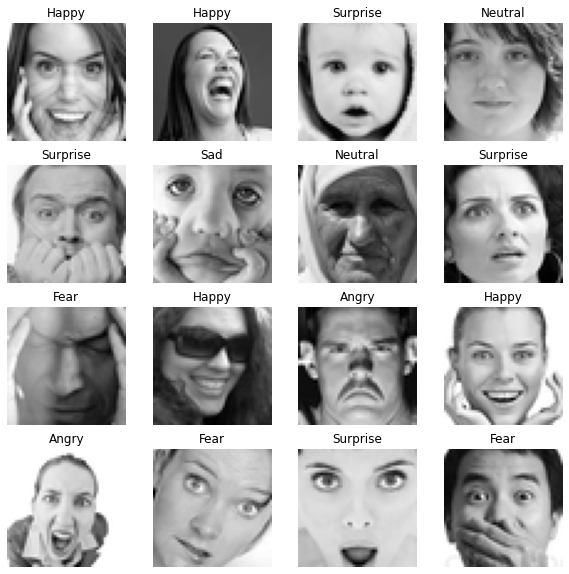

In [ ]:
random_seed = 8
# randomly select 16 images
image_sample = dataset.sample(16, random_state=random_seed)

# Create subplots for images
_, axs = plt.subplots(4, 4, figsize=(10,10))
axs = axs.ravel()
i = 0
for _, row in image_sample.iterrows():
    one_image = np.array(row['pixels']).reshape(width,height)
    axs[i].imshow(one_image, cmap='gray')
    axs[i].set_title(emotion_map[row['emotion']])
    axs[i].axis('off')
    i += 1

In [ ]:
dataset["emotion"]

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

In [ ]:
# training data
data_train = dataset[dataset['Usage']=='Training']
# reshape image data (num of images, width, height, num of channels)
x_train = np.array(data_train['pixels'].tolist(), dtype='float32').reshape(-1,width,height,1)/255.
# get labels
y_train = data_train['emotion'].to_numpy()

# validation data
data_val = dataset[dataset['Usage']!='Training']
# reshape image data (num of images, width, height, num of channels)
x_val = np.array(data_val['pixels'].tolist(), dtype='float32').reshape(-1,width,height,1)/255.
# get labels
y_val = data_val['emotion'].to_numpy()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((28709, 48, 48, 1), (28709,), (7178, 48, 48, 1), (7178,))

## 4. Model Training


In [ ]:
# set training parameters
num_train_examples = x_train.shape[0]

#if varying num_epochs
num_epochs = 450
batch_size = 230
#batch_size = int(num_train_examples/num_epochs)

#if varying batch_size
#batch_size = 50
#num_epochs = int(num_train_examples/batch_size)

# convert numpy arrays to tf tensors
training_tf = tf.data.Dataset.from_tensor_slices((x_train, y_train[:,None])).batch(batch_size)
val_tf = tf.data.Dataset.from_tensor_slices((x_val, y_val[:,None])).batch(batch_size)

num_train_examples, num_epochs, batch_size

(28709, 450, 230)

In [ ]:
nn = tf.keras.layers # neural network layer

# just if you're wondering about the layer 
# --> https://www.tensorflow.org/api_docs/python/tf/keras/layers
# --> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [ ]:
# just a typical CNN, not gonna do a VGG16.
model = tf.keras.Sequential([
    nn.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(width, height, 1),  data_format='channels_last'), #Layer 1
    nn.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"), #Layer 2
    nn.BatchNormalization(), #Layer 3
    nn.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #Layer 3
    nn.Dropout(0.5), #Layer 4 (dropout layer)

    nn.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"), #Layer 5
    nn.BatchNormalization(), #Layer 5
    nn.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"), #layer 6
    nn.BatchNormalization(), #Layer 6
    nn.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #Layer 7
    nn.Dropout(0.5), #Layer 8

    nn.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"), #Layer 9
    nn.BatchNormalization(), #Layer 9
    nn.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"), #Layer 10
    nn.BatchNormalization(), #Layer 10
    nn.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #Layer 11
    nn.Dropout(0.5), #Layer 12

    nn.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"), #Layer 13
    nn.BatchNormalization(), #Layer 13
    nn.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"), #Layer 14
    nn.BatchNormalization(), #Layer 14
    nn.MaxPooling2D(pool_size=(2,2), strides=(2,2)), #Layer 15
    nn.Dropout(0.5), #Layer 16

    nn.Flatten(),

    nn.Dense(128, activation="relu"), #Layer 16
    nn.Dropout(0.4), #Layer 17
    nn.Dense(64, activation="relu"), #Layer 18
    nn.Dropout(0.4), #Layer 19
    nn.Dense(32, activation="relu"), #Layer 20
    nn.Dropout(0.5), #Layer 21

    nn.Dense(7, activation='softmax'), #Layer 22
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # I'm not entirely sure what this does, its from the tensorflow documentation for image type of data
              metrics=['accuracy'])

In [ ]:
facial_expression = model.fit(training_tf, 
                              validation_data=val_tf, 
                              epochs=num_epochs, 
                              verbose=2,
                              use_multiprocessing=True)

Epoch 1/450
125/125 - 9s - loss: 2.0084 - accuracy: 0.2073 - val_loss: 1.8320 - val_accuracy: 0.2471
Epoch 2/450
125/125 - 9s - loss: 1.8468 - accuracy: 0.2430 - val_loss: 1.8248 - val_accuracy: 0.2471
Epoch 3/450
125/125 - 9s - loss: 1.8270 - accuracy: 0.2477 - val_loss: 1.8148 - val_accuracy: 0.2471
Epoch 4/450
125/125 - 9s - loss: 1.8199 - accuracy: 0.2507 - val_loss: 1.8169 - val_accuracy: 0.2471
Epoch 5/450
125/125 - 9s - loss: 1.8191 - accuracy: 0.2503 - val_loss: 1.8119 - val_accuracy: 0.2471
Epoch 6/450
125/125 - 9s - loss: 1.8171 - accuracy: 0.2506 - val_loss: 1.8037 - val_accuracy: 0.2471
Epoch 7/450
125/125 - 9s - loss: 1.8145 - accuracy: 0.2506 - val_loss: 1.8016 - val_accuracy: 0.2471
Epoch 8/450
125/125 - 9s - loss: 1.8118 - accuracy: 0.2502 - val_loss: 1.8060 - val_accuracy: 0.2471
Epoch 9/450
125/125 - 9s - loss: 1.8090 - accuracy: 0.2514 - val_loss: 1.8360 - val_accuracy: 0.2471
Epoch 10/450
125/125 - 9s - loss: 1.8093 - accuracy: 0.2512 - val_loss: 1.8150 - val_accura

## 5. Model Testing & Evaluation

In [ ]:
# MY CREATION SHALL PREDICT Validation Dataset
test_scores = model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)
print("Model Score\n===============================\n")
print("Loss:      " + str(test_scores[0]))
print("Accuracy:  " + str(test_scores[1]) + "\n")
# model.predict(val_tf, use_multiprocessing=True, verbose=1)

In [ ]:
# Training Dataset
train_accuracy = facial_expression.history['accuracy']
train_loss = facial_expression.history['loss']
val_accuracy = facial_expression.history['val_accuracy']
val_loss = facial_expression.history['val_loss']

In [ ]:
#Plot accuracy against epochs
x_axis = list(range(1, num_epochs+1))
plt.plot(x_axis,train_accuracy, label="Train")
plt.plot(x_axis,val_accuracy, label="Validation")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title("Accuracy against Epochs")
plt.show()


In [ ]:
#Plot loss against epochs
x_axis = list(range(1, num_epochs+1))
plt.plot(x_axis,train_loss, label="Train")
plt.plot(x_axis,val_loss, label="Validation")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title("Loss against Epochs")
plt.show()

In [ ]:
import statistics

final_train_acc = train_accuracy[len(train_accuracy)-1]
final_train_loss = train_loss[len(train_loss)-1]
final_val_acc = val_accuracy[len(val_accuracy)-1]
final_val_loss = val_loss[len(val_loss)-1]

var_acc = statistics.variance(train_accuracy)
var_loss = statistics.variance(train_loss)

final_train_acc, final_val_acc, final_train_loss, final_val_loss, var_acc, var_loss